**legacy data loding.**

using cv2 and resize to reduce dimension of the data. use if keras data loader is not working properly:

In [ ]:
# loading data
dataset = np.zeros((1818,256,256,3))
for i in range(0,1818):
  path = '/content/drive/MyDrive/data/'+ str(i)+ '.jpg'
  img = cv2.imread(path,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (256, 256),interpolation = cv2.INTER_AREA)
  img = np.array(img).astype('float16')
  img = img/255
  dataset[i] = img

**importing stuff**

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory as loadds
from tensorflow.keras.layers import Input,Dense,Conv2D,UpSampling2D,MaxPooling2D,Flatten,ZeroPadding2D,Cropping2D,Conv2DTranspose,Reshape
from tensorflow.keras.models import Model
import numpy as np
import cv2
from matplotlib import pyplot as plt


**warninng:** data loading using keras data loader, keep the batch size small due to the sheer size of the model.
free version of google colab would be enough


In [8]:
# dataset
dataset = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/data',
                                                      labels=None,
                                                      image_size= (667,500),
                                                      shuffle=True,
                                                      batch_size = 5,
                                                      color_mode = 'rgb',
                                                      crop_to_aspect_ratio=True
                                                      )
def crop_image(image):
    cropped_image = tf.image.crop_to_bounding_box(image,70,150,512, 256)
    return cropped_image


def normalize(ds):
  ds = ds/255.0
  return ds
dataset = dataset.map(normalize)
dataset = dataset.map(crop_image)


Found 1818 files belonging to 1 classes.


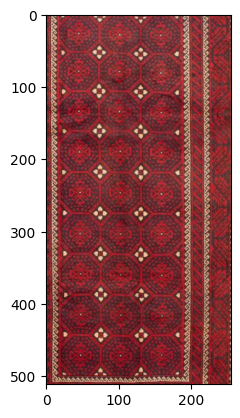

In [9]:
for x in dataset:
  x = np.array(x)
  break
plt.imshow(x[0])

In [10]:
# latent space variables
class Z_block(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
latent_dim =2
#encoder part
encoder_in = Input(shape = (512,256,3))
x = Conv2D(512,kernel_size = (5,5),padding = 'same',activation = 'elu',strides = 1)(encoder_in)
x = Conv2D(256,kernel_size = (5,5),padding = 'same',activation = 'elu',strides = (2,1))(x)
x = Conv2D(256,kernel_size = (3,3),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2D(128,kernel_size = (3,3),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2D(128,kernel_size = (3,3),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2D(32,kernel_size = (3,3),padding = 'same',activation = 'elu',strides = 2)(x)
x = Flatten()(x)
x = Dense(16,activation = 'linear')(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Z_block()([z_mean, z_log_var])
encoder = Model(encoder_in, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 256, 51  38912       ['input_1[0][0]']                
                                2)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 25  3277056     ['conv2d[0][0]']                 
                                6)                                                          

In [14]:
# decoder part
latent_out = Input(shape=(latent_dim,))
x = Dense(16*8*8,activation = 'elu')(latent_out)
x = Reshape((16,8,8))(x)
x = Conv2DTranspose(512,kernel_size = (4,4),padding = 'same',activation = 'elu',strides = 1)(x)
x = Conv2DTranspose(256,kernel_size = (4,4),padding = 'same',activation = 'elu',strides = 1)(x)
x = Conv2DTranspose(256,kernel_size = (4,4),padding = 'same',activation = 'elu',strides = 1)(x)
x = Conv2DTranspose(128,kernel_size = (4,4),padding = 'same',activation = 'elu',strides = 1)(x)
x = Conv2DTranspose(128,kernel_size = (4,4),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2DTranspose(64,kernel_size = (4,4),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2DTranspose(64,kernel_size = (4,4),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2DTranspose(32,kernel_size = (4,4),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2DTranspose(32,kernel_size = (4,4),padding = 'same',activation = 'elu',strides = 2)(x)

x = Conv2DTranspose(1,kernel_size = (4,4),padding = 'same',activation = 'linear',strides = 1)(x)
decoder = Model(latent_out,x,name = 'decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 1024)              3072      
                                                                 
 reshape_2 (Reshape)         (None, 16, 8, 8)          0         
                                                                 
 conv2d_transpose_19 (Conv2D  (None, 16, 8, 512)       66048     
 Transpose)                                                      
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 16, 8, 256)       2097408   
 Transpose)                                                      
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 16, 8, 256)       1048

In [15]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.keras.losses.mse(data, reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [16]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())


In [ ]:
vae.fit(dataset,epochs =3)

Epoch 1/3
 56/364 [===>..........................] - ETA: 11:23 - loss: 2656.8008 - reconstruction_loss: 0.1589 - kl_loss: 1854.9777

364/364 [==============================] - 12s 31ms/step


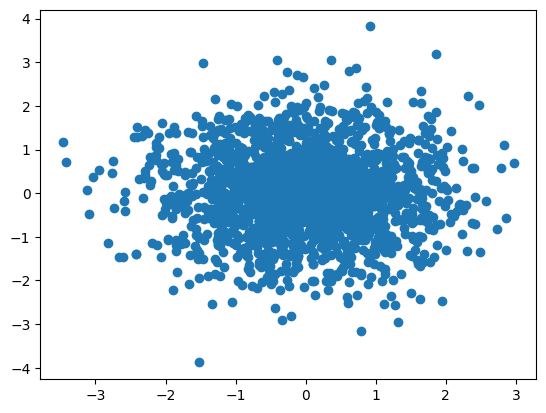

In [ ]:
y = vae.encoder.predict(dataset)
y = np.array(y)[2]
plt.scatter(y[:,0],y[:,1])

1/1 [==============================] - 0s 30ms/step


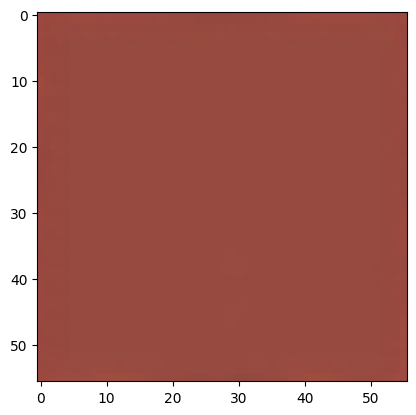

In [ ]:
p = vae.decoder.predict(3*np.ones((1,2)))
plt.imshow(p[0])

FloatSlider(value=0.12, continuous_update=False, description='dimension1', layout=Layout(width='80%'), max=3.0…

FloatSlider(value=-0.52, continuous_update=False, description='dimension2', layout=Layout(width='80%'), max=3.…

FloatSlider(value=0.24, continuous_update=False, description='dimension3', layout=Layout(width='80%'), max=3.0…

FloatSlider(value=0.69, continuous_update=False, description='dimension4', layout=Layout(width='80%'), max=3.0…

Button(description='Execute', style=ButtonStyle())

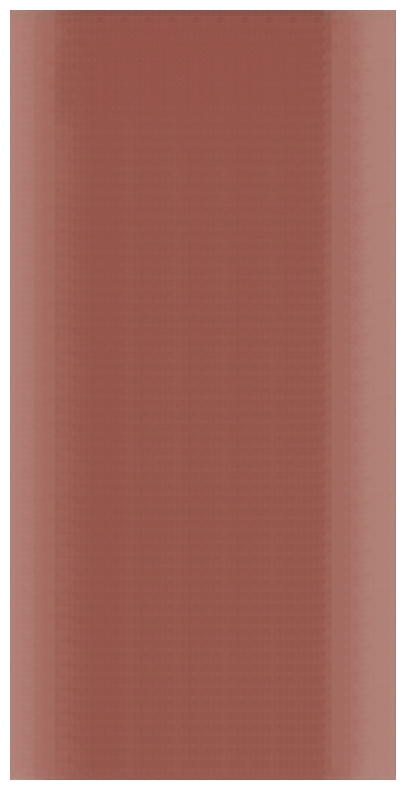

In [10]:
from IPython.display import display
import ipywidgets as widgets
from IPython.display import display, Image, clear_output

plt.figure(figsize= (20,20))
def func(sliders):
    # Clear the previous image
    clear_output(wait=True)
    z_input = np.zeros((1, latent_dim))
    for i, slider in enumerate(sliders):
        z_input[0, i] = slider.value

    out_pic = vae.decoder.predict(z_input, verbose=False)
    display(*sliders,button)
    # Display the new image
    plt.figure(figsize= (10,10))
    plt.imshow(out_pic[0])
    plt.axis('off')
    plt.show()


s = []
for dim in range(1,latent_dim+1):
  w = widgets.FloatSlider(
    value=0,
    min=-3,
    max=3,
    step=0.01,
    description='dimension'+str(dim),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.6f',
    layout=widgets.Layout(width='80%')
  )
  display(w)
  s.append(w)
button = widgets.Button(description="Execute")
button.on_click(lambda _: func(s))
display(button)
